<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/Simple_PDE_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# In this notebook, we solve simple partial differerential equations with tensorflow 2.0.

We apply the PINN methodology seen [here](https://github.com/maziarraissi/PINNs)

In this notebook, we look at the one dimensional wave equation on [0,3] in space, and time interval in [0., 9.].

$u_{tt} = c^2 u_{xx}$.

Here we inpose the periodic boundary condition

$u(0,t) = u(3,t)$.

With an exact (periodic) solution

$\phi(x,t) = \sin(2\pi\xi (x-ct))e^{-\beta(x-ct-0.5)^2}$,

we impose corresponding initial conditions at $t=0$.

In this notebook, we take $c=1$, $\beta = 16$, and $\xi = \frac{1}{4\Delta x}$.

Here $\xi = 249.91666666666666$.



In [1]:
# Generate xi from Finite Difference parameters
# import numpy as np
# n = 5000
# gamma = 0.6
# space = [0., 3.]
# x = np.linspace(space[0], space[1], int(gamma * n))
# t = np.linspace(0, 9, n)
# xi = 1 / (4 * x[1])
# print(xi)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [3]:
# Set date type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

EPOCH = 5000

# set constant- need to be tensors
pi = tf.constant(np.pi, dtype = DTYPE)
c = tf.constant(1., dtype = DTYPE)
beta = tf.constant(16., dtype = DTYPE)
xi = tf.constant(249.91666666666666, dtype = DTYPE)

# define initial conditions
def u_0(x)-> tf.Tensor:
  return tf.sin(2 * pi * xi * x) * tf.exp(-beta * (x - 0.5) **2)

# boundary conditions: u(lb,t) == u(ub,t), put in loss function

# Define residual of the PDE
def fun_r(u_xx, u_tt)-> tf.Tensor:
    return u_tt - c **2 * u_xx

Define points where initial, boundary, and interior data are evaluated.

Take 50 points in time, and 50 points in space for initial and boundary conditions. We take a total of 10000 points in the interior.
$N_0 = 50,\ N_b = 50,\ N_r = 10000$.

In [4]:
# Set number of data points
N_0 = 50 # number of points in space
N_b = 50 # number of points in time
N_r = 10000

# Set boundary
tmin = 0.
tmax = 9.
xmin = 0.
xmax = 3.

# Lower bounds in time and space
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds in time and space
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data; need N_0 == N_b for concat
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0--------> maybe missing another initial condition for ut_0??
u_0 = u_0(x_0)

# Boundary data- we compare left and right boundary at give time steps.
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
X_lb = tf.concat([t_b, x_lb], axis=1)
X_ub = tf.concat([t_b, x_ub], axis=1)

# Boundary condition are evaluated in the loss function
# u(t_b, x_lb) = u(t_b, x_ub)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# # Collect boundary and inital data in lists<----- not needed in this code; no u_b
# X_data = [X_0, X_b]
# u_data = [u_0, u_b]

In [5]:
## test cell to understand input variables

# print(tf.size(X_r))
# print(len(X_r))
# t, x = X_r[:, 0:1], X_r[:,1:2]

# X_rr = tf.stack([t[:,0], x[:,0]], axis=1)

# print(tf.size(X_r))
# print(tf.size(X_rr))

# print(X_r - X_rr)

# print(X_0[1])
# print(X_lb[1])
# print(X_ub[1])
# print(X_r[1])
# print(u_0)

# print(len(X_0[1]))
# print(len(X_lb[1]))
# print(len(X_ub[1]))
# print(len(X_r[1]))

# print(X_0[1])
# print(X_lb[1])
# print(X_ub[1])
# print(X_r[1])

# f = lambda x: 2.0*(x - lb)/(ub - lb) - 1.0
# print(f([9., 3.]))

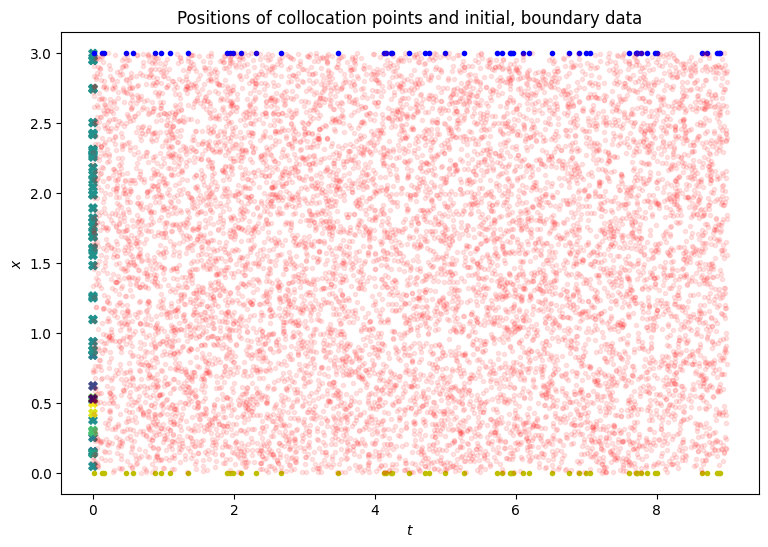

In [6]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_lb, c='y', marker='.')
plt.scatter(t_b, x_ub, c='b', marker='.')
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and initial, boundary data');
#plt.savefig('collocation_points_wave.pdf', bbox_inches='tight', dpi=300)

## Set up network.

The neural net takes two inputs- time and space;

The input is scaled elementwise to lie in the interval [-1, 1].

By default, the neural net has 8 layers, with 20 neurons on each layer, and hyperbolic tangent activation function.

One fully connected output layer.

In [7]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

## Determine loss and gradient


In [8]:
def get_r(model, X_r)-> tf.Tensor:

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)

    u_tt = tape.gradient(u_t, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(u_xx, u_tt)

The loss will include the three parts (see Raissi's Schrodinger example for periodic boundary condition).

The loss has three parts: initial loss between true and predicted; physics informed loss; the periodic boundary condition for the predicted solution.

Physics-informed loss is computed at `X_r`, initial loss is computed at `X_0` with `u_0`, and periodic boundary loss is computed at `X_b`.

Physics informed loss is computed via the NN model, then the residual; initial and boundary errors are computed with the NN model directly, then compared with true value or condition.

In [9]:
model = init_model(num_hidden_layers = 2)
r = get_r(model, X_0)
phi_r = tf.reduce_mean(tf.square(r))
loss = phi_r

print(X_0.shape)
print(X_0[1].shape)



(50, 2)
(2,)


In [10]:
def compute_loss(model, X_r, X_0, X_lb, X_ub, u_0)-> tf.Tensor:

    # Compute phi^r-- physics informed loss
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add initial error the loss
    u_pred = model(X_0)
    loss += tf.reduce_mean(tf.square(u_0 - u_pred))



    # add boundary error in the loss compute the boundary difference.

    ul_pred = model(X_lb)
    uu_pred = model(X_ub)
    loss += tf.reduce_mean(tf.square(ul_pred - uu_pred))

    return loss

In [11]:
loss = compute_loss(model, X_r, X_0, X_lb, X_ub, u_0)

Compute gradient of the loss

In [12]:
def get_grad(model, X_r, X_0, X_lb, X_ub, u_0):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_0, X_lb, X_ub, u_0)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

Set up optimizer and train model. We use a piecewise learning rate.

In [13]:
# Initialize model aka u_\theta
model = init_model(num_hidden_layers = 2)
# print(model.layers[0].input_shape)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Train model

In [14]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step()-> tf.Tensor:
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_0, X_lb, X_ub, u_0)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
# N = 5000
hist = []

# Start timer
t0 = time()

for i in range(EPOCH+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 6.13980651e-01
It 00050: loss = 7.40383193e-02
It 00100: loss = 7.35526830e-02
It 00150: loss = 7.34340549e-02
It 00200: loss = 7.33624250e-02
It 00250: loss = 7.33214989e-02
It 00300: loss = 7.32985437e-02
It 00350: loss = 7.32839182e-02
It 00400: loss = 7.32734203e-02
It 00450: loss = 7.32650608e-02
It 00500: loss = 7.32575208e-02
It 00550: loss = 7.32498765e-02
It 00600: loss = 7.32414797e-02
It 00650: loss = 7.32317641e-02
It 00700: loss = 7.32201338e-02
It 00750: loss = 7.32057393e-02
It 00800: loss = 7.31874183e-02
It 00850: loss = 7.31634572e-02
It 00900: loss = 7.31315836e-02
It 00950: loss = 7.30891749e-02
It 01000: loss = 7.30348751e-02
It 01050: loss = 7.30275810e-02
It 01100: loss = 7.30210617e-02
It 01150: loss = 7.30142221e-02
It 01200: loss = 7.30070695e-02
It 01250: loss = 7.29996338e-02
It 01300: loss = 7.29918927e-02
It 01350: loss = 7.29838908e-02
It 01400: loss = 7.29755983e-02
It 01450: loss = 7.29670972e-02
It 01500: loss = 7.29583502e-02
It 01550

# Plot solution

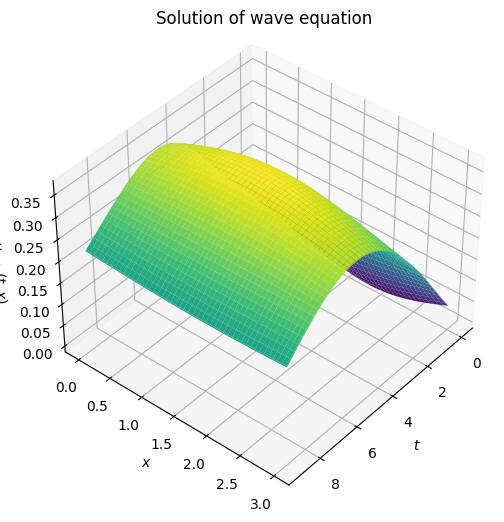

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(40,40)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_{\theta}(t,x)$')
ax.set_title('Solution of wave equation');
#plt.savefig('wave_Solution.pdf', bbox_inches='tight', dpi=300);

# Plot loss as a function of time

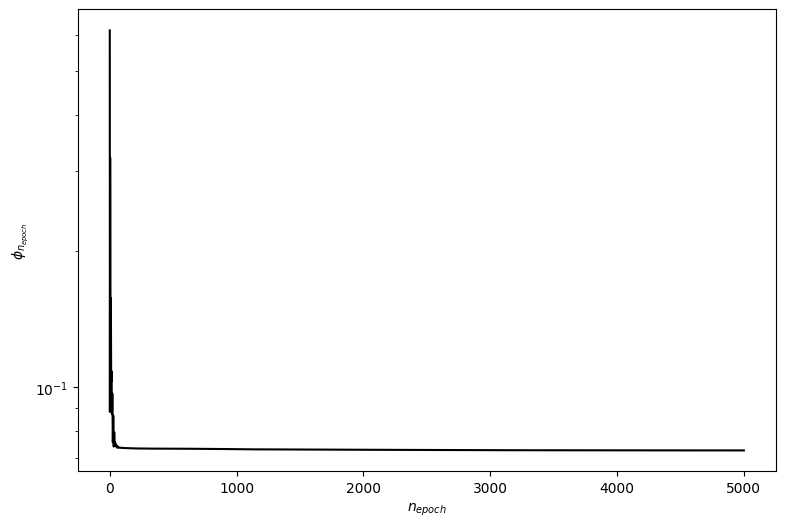

In [16]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');